# Imports

In [1]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
import numpy as np
import IPython.display
import cv2
import pydicom._storage_sopclass_uids

from os import walk
from ipywidgets import interact
from skimage.transform import radon, iradon, rescale
from datetime import datetime
from pydicom.dataset import Dataset, FileDataset
from pydicom.uid import ExplicitVRLittleEndian
from skimage.util import img_as_ubyte
from skimage.exposure import rescale_intensity
from scipy.fft import fft

# Configuration

In [2]:
pic_dir = "photos/"
dicom_dir = "dicom_examples/"

# Loading and preprocess files

In [3]:
filenames = next(walk(pic_dir), (None, None, []))[2]  # [] if no file
images = dict()

for file in filenames:
    img = cv2.imread(pic_dir+file, cv2.IMREAD_GRAYSCALE)
    
    # fill backgorund
    h, w = img.shape
    diagonal = np.round(np.sqrt(h**2 + w**2)).astype(int)
    new_shape = (diagonal, diagonal)
    large_img = np.zeros(new_shape)
    x0 = (diagonal - h) // 2
    y0 = (diagonal - w) // 2
    large_img[y0:y0+h, x0:x0+w] = img
    
    images[file.split('.')[0]] = large_img

# Bresenham algorithm

In [4]:
def bresenham(p1, p2):
    assert isinstance(p1, tuple), "First argument should be tuple"
    assert isinstance(p2, tuple), "Second argument should be tuple"
    
    x1, y1 = p1
    x2, y2 = p2
    pixels = []
    dx = abs(x2-x1)
    dy = abs(y2-y1)
    
    if x1 < x2: dir_x = 1
    else: dir_x = -1
        
    if y1 < y2: dir_y = 1
    else: dir_y = -1
    
    err = dx - dy
    
    while True:
        pixels.append((x1, y1))
        if x1 == x2 and y1 == y2:
            break
        e = 2 * err
        if e > -dy:
            err -= dy
            x1 += dir_x
        if e < dx:
            err += dx
            y1 += dir_y
    
    return pixels
print(bresenham((1,1), (6,5)))

[(1, 1), (2, 2), (3, 3), (4, 3), (5, 4), (6, 5)]


# Radon transform
#### Parallel model
### Setting parameters

In [5]:
@interact
def set_parameters(_image=list(images.keys()),
                    _detectors=widgets.IntSlider(min=100,max=1000,step=100,value=500),
                    _phi=widgets.IntSlider(min=30,max=300,step=30,value=180),
                    _delta=widgets.FloatSlider(min=0.1,max=5,step=0.1,value=1)):
    
    global delta, phi, detector_num, img
    delta = _delta # shift angle
    phi = _phi # span angle
    detector_num = _detectors # amount of detectors/emmiters in one iteration
    img = images[_image]
    
    plt.imshow(images[_image], cmap='gray')
    

interactive(children=(Dropdown(description='_image', options=('CT_ScoutView', 'Kolo', 'Kwadraty2', 'SADDLE_PE-…

#### Run radon transform

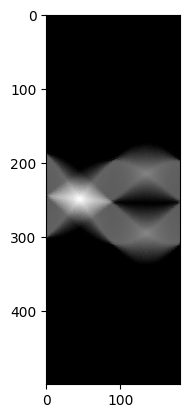

In [22]:
def radon_transform(img, detector_num, delta, phi, show_iter=True, faster=False, filtering=True, kernel_size=11):
    
    if faster:
        img = rescale(img, scale=0.2) # little worse effect but much faster
    
    if filtering:
        kernel = [1 if k == 0 else 0 if k % 2 == 0 else (-4*np.pi**2 / k**2) for k in range(-kernel_size//2,kernel_size//2+1)]

    x0, y0 = img.shape[0] // 2, img.shape[1] // 2 # center coordinates
    angles = np.arange(0, 180 + delta, delta)
    sinogram = np.zeros((len(angles), detector_num))
    r = img.shape[0] / 2

    for i, alpha in enumerate(angles):
        angles_det = np.deg2rad(np.linspace(0, phi, detector_num) + alpha - phi/2)
        angles_emit = np.deg2rad(np.linspace(0, phi, detector_num) + alpha - phi/2 + 180)

        detectors = np.zeros((detector_num, 2), dtype=int)
        emitters = np.zeros((detector_num, 2), dtype=int)

        for j, (angle_det, angle_emit) in enumerate(zip(angles_det, angles_emit)):
            xd = np.round(r * np.cos(angle_det) - x0).astype(int)
            yd = np.round(r * np.sin(angle_det) - y0).astype(int)
            xe = np.round(r * np.cos(angle_emit) - x0).astype(int)
            ye = np.round(r * np.sin(angle_emit) - y0).astype(int)
            detectors[j][0], detectors[j][1] = xd, yd
            emitters[detector_num-j-1][0], emitters[detector_num-j-1][1] = xe, ye

        pixels = np.zeros(detector_num, None)
        for j, (det_coord, emit_coord) in enumerate(zip(detectors, emitters)):
            beam_coord = bresenham(tuple(det_coord), tuple(emit_coord))
            pixels[j] = np.mean([img[coord] for coord in beam_coord])
        
        sinogram[i,] = pixels
        
        if filtering:
            sinogram[i,] = np.max(sinogram[i,]) - np.convolve(sinogram[i,], kernel, 'same')
        
        if show_iter:
            plt.imshow(sinogram.T, cmap='gray')
            plt.show()
            IPython.display.clear_output(wait=True)

    return sinogram

sinogram = radon_transform(img, detector_num, delta, phi, faster=True, filtering=False)

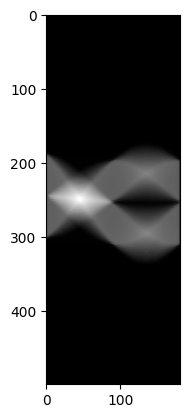

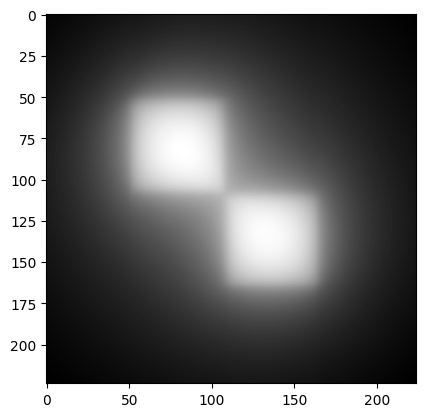

In [31]:
def apply_filter(sinogram, kernel_size):
    kernel = [1 if k == 0 else 0 if k % 2 == 0 else (-4*np.pi**2 / k**2) for k in range(-kernel_size//2, kernel_size//2+1)]

    filtered_sinogram = np.zeros_like(sinogram)
    for i in range(sinogram.shape[0]):
        # filtered_sinogram[i,] += np.convolve(sinogram[i,], kernel, mode='same')
        # filtered_sinogram[:,j] = np.max(sinogram[:,j]) - np.convolve(sinogram[:,j], kernel, mode='same')
        filtered_sinogram[i,] = np.max(sinogram[i,]) -  np.convolve(sinogram[i,], kernel, mode='same')
        
    return filtered_sinogram


#for k in range(1, 1000):
#    sin2 = apply_filter(sinogram.T, k)
#    plt.imshow(sin2, cmap='gray')
#    plt.show()
#    IPython.display.clear_output(wait=True)


sin_norm = MinMax(sinogram)
sin2 = apply_filter(sin_norm.T, 10)
plt.imshow(sin2, cmap='gray')
plt.show()
reconstructed = inverse_radon_transform(sin2, delta, show_iter=False)
plt.imshow(reconstructed,cmap='gray')
plt.show()

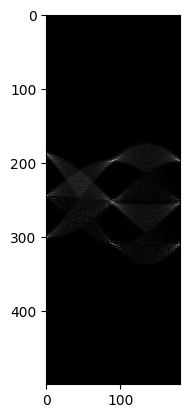

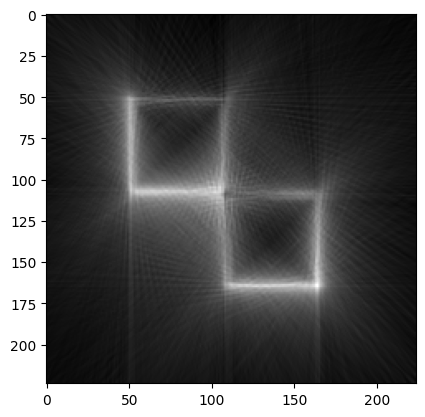

In [32]:
import scipy
from scipy import misc, ndimage

def detect_edges(image,masks):
    edges=np.zeros(image.shape)
    for mask in masks:
        edges=np.maximum(scipy.ndimage.convolve(image, mask), edges)
    return edges

pic = sinogram

Faler=[ [[-1,0,1],[-1,0,1],[-1,0,1]], 
        [[1,1,1],[0,0,0],[-1,-1,-1]],
    [[-1,-1,-1],[-1,8,-1],[-1,-1,-1]],
    [[0,1,0],[-1,0,1],[0,-1,0]] ]


edges=detect_edges(sinogram.T, Faler)
plt.imshow(edges, cmap='gray')
plt.show()
edg = inverse_radon_transform(edges, delta, show_iter=False)
plt.imshow(edg,cmap='gray')
plt.show()

# Inverse radon

In [11]:
# http://rknet.pl/student/2013_2014/pom/wyk/POM_Radon_Hough.pdf

In [114]:
img.shape

(1448, 1448)

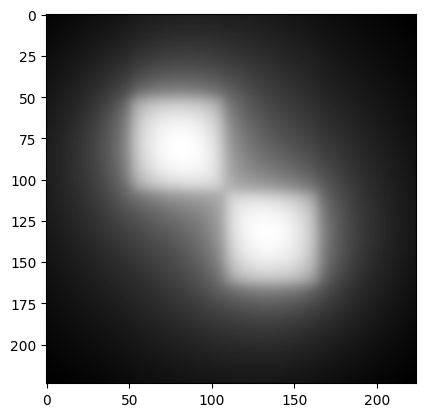

In [20]:
def inverse_radon_transform(sinogram, delta, out_scale=5.0, show_iter=True):
    
    angles = np.arange(0, 180 + delta, delta)
    detectors_num = sinogram.shape[0]
    size = np.round(np.sqrt((detectors_num) ** 2 / out_scale)).astype('int')
    reconstr_img = np.zeros((size, size))
    x0, y0 = np.mgrid[:size, :size] - size // 2
    x = np.arange(detectors_num) - detectors_num // 2
    angles = np.deg2rad(angles)

    for col, angle in zip(sinogram.T, angles):
        s = -x0 * np.sin(angle) + y0 * np.cos(angle)
        # t = x0 * np.cos(angle) + y0 * np.cos(angle)
        reconstr_img += np.interp(s, x, col)
       
        if show_iter:
            plt.imshow(reconstr_img, cmap='gray')
            plt.show()   
            IPython.display.clear_output(wait=True)
        
    return reconstr_img

reconstructed = inverse_radon_transform(sinogram.T, delta)

In [24]:
def MinMax(v):
    return (v - np.min(v)) / (np.max(v) - np.min(v))

#### RMSe

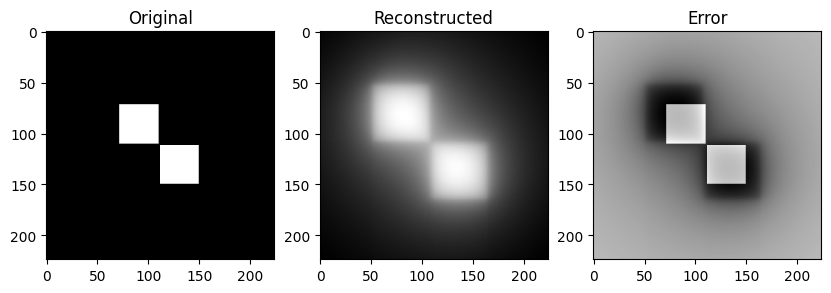

RMSe after MinMax scalling = 0.31


In [186]:
img_reshaped_norm = MinMax(cv2.resize(img, reconstructed.shape))
reconstructed_norm = MinMax(reconstructed)
err = img_reshaped_norm - reconstructed_norm

plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
plt.imshow(img_reshaped_norm,cmap='gray')
plt.title('Original')
plt.subplot(1,3,2)
plt.imshow(reconstructed_norm, cmap='gray')
plt.title('Reconstructed')
plt.subplot(1,3,3)
plt.imshow(err, cmap='gray')
plt.title('Error')
plt.show()

rmse = np.sqrt(np.mean((reconstructed_norm - img_reshaped_norm)**2))
print(f'RMSe after MinMax scalling = {round(rmse,2)}')

#### Comparison with skimage built-in function

In [20]:
@interact
def radon_check(image=list(images.keys())):
    plt.figure(figsize=(10,3))
    
    plt.subplot(1,3,1)
    img  = rescale(images[image], scale=0.2)
    plt.imshow(img, cmap='gray')
    
    plt.subplot(1,3,2)
    sinogram = radon(img)
    plt.imshow(sinogram, cmap='gray')
    
    plt.subplot(1,3,3)
    reconstr = iradon(sinogram)
    plt.imshow(reconstr, cmap='gray')
    
    plt.show()

interactive(children=(Dropdown(description='image', options=('CT_ScoutView', 'Kolo', 'Kwadraty2', 'SADDLE_PE-l…

# Save and read DICOM

In [81]:
def convert_image_to_ubyte(img):
    return img_as_ubyte(rescale_intensity(img, out_range=(0.0, 1.0)))

def save_as_dicom(file_name, img, patient_data):
    img_converted = convert_image_to_ubyte(img)
    
    # Populate required values for file meta information
    meta = Dataset()
    meta.MediaStorageSOPClassUID = pydicom._storage_sopclass_uids.CTImageStorage
    meta.MediaStorageSOPInstanceUID = pydicom.uid.generate_uid()
    meta.TransferSyntaxUID = pydicom.uid.ExplicitVRLittleEndian  

    ds = FileDataset(None, {}, preamble=b"\0" * 128)
    ds.file_meta = meta

    ds.is_little_endian = True
    ds.is_implicit_VR = False

    ds.SOPClassUID = pydicom._storage_sopclass_uids.CTImageStorage
    ds.SOPInstanceUID = meta.MediaStorageSOPInstanceUID
    
    ds.PatientName = patient_data["PatientName"]
    ds.PatientID = patient_data["PatientID"]
    ds.ImageComments = patient_data["ImageComments"]
    ds.StudyDate = patient_data["StudyDate"]

    ds.Modality = "CT"
    ds.SeriesInstanceUID = pydicom.uid.generate_uid()
    ds.StudyInstanceUID = pydicom.uid.generate_uid()
    ds.FrameOfReferenceUID = pydicom.uid.generate_uid()

    ds.BitsStored = 8
    ds.BitsAllocated = 8
    ds.SamplesPerPixel = 1
    ds.HighBit = 7

    ds.ImagesInAcquisition = 1
    ds.InstanceNumber = 1

    ds.Rows, ds.Columns = img_converted.shape

    ds.ImageType = r"ORIGINAL\PRIMARY\AXIAL"

    ds.PhotometricInterpretation = "MONOCHROME2"
    ds.PixelRepresentation = 0

    pydicom.dataset.validate_file_meta(ds.file_meta, enforce_standard=True)

    ds.PixelData = img_converted.tobytes()

    ds.save_as(file_name, write_like_original=False)
    
    print('Image saved successfully')
    
def read_dicom(filename):
    ds = pydicom.dcmread(filename)
    return ds.pixel_array
    

#### Save

In [94]:
filename = input("Enter file name: ")
patient_data = {}
patient_data["PatientName"] = input("Enter patient name: ")
patient_data["PatientID"] = input("Enter patient id: ") # str(np.random.randint(0,10000))
patient_data["ImageComments"] = input("Enter comments: ")
patient_data["StudyDate"] = datetime.now().date().strftime('%Y%m%d')

dicom_img = convert_image_to_ubyte(reconstructed)
save_as_dicom(dicom_dir+filename+'.dcm', dicom_img, patient_data)

Enter file name:  Reconstructed-dot
Enter patient name:  John
Enter patient id:  1111
Enter comments:  ...


Image saved successfully


#### Read

In [95]:
filenames = next(walk(dicom_dir), (None, None, []))[2]
dicom_images = dict()
dicom_data = dict()

for file in filenames:
    dicom_img = read_dicom(dicom_dir+file)
    dicom_images[file.split('.')[0]] = dicom_img
    
    d_data = pydicom.dcmread(dicom_dir+file)
    dicom_data[file.split('.')[0]] = d_data

In [96]:
@interact
def overview(_image=list(dicom_images.keys())):
    
    ds = dicom_data[_image]
    img = dicom_images[_image]    
    plt.imshow(img, cmap='gray')
    print(ds)
    

interactive(children=(Dropdown(description='_image', options=('Kropka', 'SADDLE_PE', 'Kwadraty2', 'CT_ScoutVie…